# Assignment 1 

This assignment was submitted to the class of 2021/1 for the course MO444 - Introduction to Machine Learning at Universidade Estadual de Campinas. Its goal is to apply unsupervised learning methods to solve clustering and dimensionality reduction in two distinct task.

This notebook is better visualized on Colab, where helpers and unimportant sections are hidden. 

**Authors**
- Lucas David  
  188972  
  <lucas.david@ic.unicamp.br>

  Contributions:
  - K-Means
  - Metrics
  - Support with the PCA application
  - Selected the TF-Flowers Dataset
  - Wrote discussion sections for both methods

- Jonathan Nunes  
  146667  
  <j146667@dac.unicamp.br>

  Contributions:
  - Selected the Boston Dataset
  - Hierarchical Clustering
  - Implemented the PCA
  - Wrote discussion sections for both methods

**Instructions**

1. Set the variable `Config.cluster_dat.source` to point to a valid location of the `cluster.dat` file.
2. If your file is in your Google Drive, make sure to run cell `6` and authenticate with your Google account.

**Links**
- Colab: https://colab.research.google.com/drive/1KC6MhKuFry0zvUhZ45-Bp5tJp2Fkh1kq?usp=sharing

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns

In [2]:
class Config:
  class cluster_dat:
    k_init_method = 'kpp'
    k_max = 10
    repeats = 100
    steps = 30
    tol = .0001

    test_size = 0.1
    source = '/content/drive/MyDrive/datasets/MO444/cluster.dat'

  class boston:
    k_init_method = 'kpp'
    k_max = 10
    repeats = 100
    steps = 100
    tol = .0001

    test_size = 0.1

  class tf_flowers:
    colors = 128  # k, actually
    training_samples = 10000
    steps = 100
    tol = .01

    test_size = 0.1
    batch_size = 8
    buffer_size = batch_size * 8
    image_sizes = (150, 150)
    channels = 3
    shape = (*image_sizes, channels)

  class run:
    palette = sns.color_palette("husl", 3)
    # seed = 472
    seed = 821

## Setup

In [3]:
tf.random.set_seed(Config.run.seed)
np.random.seed((Config.run.seed//4 + 41) * 3)

In [4]:
import logging
from math import ceil
from typing import (Dict, List, Set, Any,
                    Union, Callable)

import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

In [5]:
sns.set()
sns.set_palette(Config.run.palette)

In [6]:
if Config.cluster_dat.source.startswith('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


### Utils

In [7]:
def split_dataset(*tensors, test_size):
  s = tensors[0].shape[0]

  indices = tf.range(s)
  indices = tf.random.shuffle(indices)

  train_indices, test_indices = (indices[int(test_size*s):],
                                 indices[:int(test_size*s)])
  
  return sum(((tf.gather(x, train_indices, axis=0),
               tf.gather(x, test_indices, axis=0))
              for x in tensors), ())

def standardize(x, center=True, scale=True, return_stats=False, axis=0):
  """Standardize data based on its mean and standard-deviation [4].
  """
  u, s = None, None
  if center:
    u = tf.reduce_mean(x, axis=axis, keepdims=True)
    x = x-u

  if scale:
    s = tf.math.reduce_std(x, axis=axis, keepdims=True)
    x = tf.math.divide_no_nan(x, s)
  
  if return_stats:
    return x, (u, s)

  return x


def inverse_standardize(x, u, s):
  if s is not None: x = x*s
  if u is not None: x = x+u
  return x

def size_in_mb(x):
  return tf.reduce_prod(x.shape)*8 / 1024**2

In [8]:
def visualize_clusters(*sets, title=None, full=True, legend=True):
  d = pd.concat([
    pd.DataFrame({
      'x': features[:, 0],
      'y': features[:, 1],
      'cluster': [f'cluster {l}' for l in np.asarray(labels).astype(str)],
      'subset': [subset] * features.shape[0]
    })
    for features, labels, subset, _ in sets
  ])

  if full: plt.figure(figsize=(9, 6))
  if title: plt.title(title)

  markers = {s: m for _, _, s, m in sets}
  sns.scatterplot(data=d, x='x', y='y', hue='cluster', style='subset', markers=markers, legend=legend)
  if full: plt.tight_layout()


def visualize_images(
    image,
    title=None,
    rows=2,
    cols=None,
    cmap=None,
    figsize=(14, 6)
):
  if image is not None:
    if isinstance(image, list) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize_images(
          image[ix],
          cmap=cmap,
          title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

## Datasets

In this section, we present the datasets used in this assignment.
They were selected considering their diverse nature, in order to visualize the behavior of clustering/dimensionality reduction techniques in different scenarios.

### cluster.dat

This dataset was provided during class. It comprises 573 samples and 2 numeric features.

In [9]:
cluster_train = tf.constant(np.genfromtxt(Config.cluster_dat.source), tf.float32)

cluster_train, cluster_test = split_dataset(
  cluster_train,
  test_size=Config.cluster_dat.test_size
)

cluster_s_train, (c_u, c_s) = standardize(cluster_train, return_stats=True)
cluster_s_test = standardize(cluster_test)

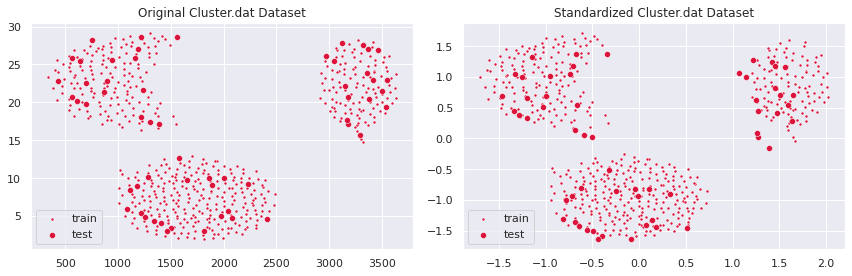

In [10]:
#@title

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Original Cluster.dat Dataset')
sns.scatterplot(x=cluster_train[:, 0], y=cluster_train[:, 1], label='train', marker='.', color='crimson')
sns.scatterplot(x=cluster_test[:, 0], y=cluster_test[:, 1], label='test', color='crimson');

plt.subplot(122)
plt.title('Standardized Cluster.dat Dataset')
sns.scatterplot(x=cluster_s_train[:, 0], y=cluster_s_train[:, 1], label='train', marker='.', color='crimson')
sns.scatterplot(x=cluster_s_test[:, 0], y=cluster_s_test[:, 1], label='test', color='crimson')

plt.tight_layout();

In [11]:
cluster_train, cluster_test = cluster_s_train, cluster_s_test
del cluster_s_train, cluster_s_test

### Boston

This dataset represents the association between physical and social attributes of properties in Boston and their respective evaluations (in thousands of dollars) [3].
In here, we use the Boston dataset to illustrate an structured ML problem.

It comprises 506 samples and 13 features.
For the purposes of our analysis, we opted to remove the column `B`, described as [3]:

    - B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town


In [12]:
from sklearn.datasets import load_boston

boston = load_boston()
boston_feature_names = np.delete(boston.feature_names, -2)

boston_x_train = np.delete(boston.data, -2, axis=1).astype(np.float32)
boston_y_train = boston.target.astype(np.float32)

(boston_x_train, boston_x_test, boston_y_train, boston_y_test) = split_dataset(
  boston_x_train,
  boston_y_train,
  test_size=Config.boston.test_size,
)

boston_s_train, (b_u, b_s) = standardize(boston_x_train, return_stats=True)
boston_s_test = standardize(boston_x_test)

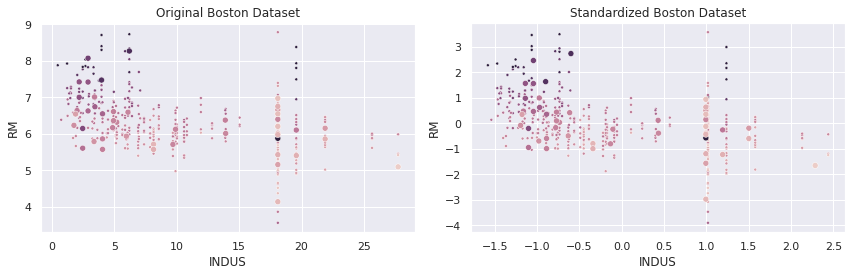

In [13]:
#@title

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Original Boston Dataset')
sns.scatterplot(x=boston_x_train[:, 2], y=boston_x_train[:, 5], hue=boston_y_train, marker='.', label='train', legend=False)
sns.scatterplot(x=boston_x_test[:, 2], y=boston_x_test[:, 5], hue=boston_y_test, label='test', legend=False)
plt.xlabel(boston_feature_names[2])
plt.ylabel(boston_feature_names[5])

plt.subplot(122)
plt.title('Standardized Boston Dataset')
sns.scatterplot(x=boston_s_train[:, 2], y=boston_s_train[:, 5], hue=boston_y_train, marker='.', label='train', legend=False)
sns.scatterplot(x=boston_s_test[:, 2], y=boston_s_test[:, 5], hue=boston_y_test, label='test', legend=False)
plt.xlabel(boston_feature_names[2])
plt.ylabel(boston_feature_names[5])
plt.tight_layout();

In [14]:
boston_x_train, boston_x_test = boston_s_train, boston_s_test
del boston_s_train, boston_s_test

### TF-Flowers

We utilize [TF-Flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset to illustrate the application of K-Means in Color Quantization.

This dataset represents a multi-class (mono-label) image classification problem, and comprises 3,670 photographs of flowers associated with one of the following labels: *dandelion*, *daisy*, *tulips*, *sunflowers* or *roses*.

In [15]:
#@title

def preprocessing_fn(image, label):
  current = tf.cast(tf.shape(image)[:2], tf.float32)
  target = tf.convert_to_tensor(Config.tf_flowers.image_sizes, tf.float32)
  ratio = tf.reduce_max(tf.math.ceil(target / current))
  new_sizes = tf.cast(current*ratio, tf.int32)

  image = tf.image.resize(image, new_sizes, preserve_aspect_ratio=True)
  image = tf.image.resize_with_crop_or_pad(image, *Config.tf_flowers.image_sizes)

  return image, label


def prepare(ds):
  return (ds.shuffle(Config.tf_flowers.buffer_size)
            .map(preprocessing_fn, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(Config.tf_flowers.batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))


def load_tf_flowers():
  (train_ds, test_ds), info = tfds.load(
    'tf_flowers',
    split=['train[:50%]', 'train[50%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=False)
  
  train_ds = prepare(train_ds)
  test_ds = prepare(test_ds)
  
  train_ds.info = info
  train_ds.int2str = info.features['label'].int2str

  return train_ds, test_ds

In [16]:
flowers_train_set, flowers_test_set = load_tf_flowers()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


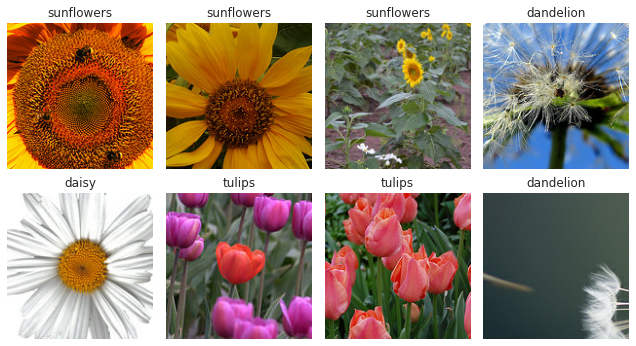

In [17]:
#@title

images, target = next(iter(flowers_train_set))
labels = [flowers_train_set.int2str(l) for l in target]

visualize_images(
  tf.cast(images, tf.uint8),
  labels,
  figsize=(9, 5)
)

## Part-1: Clustering Methods

### K-Means

Our K-Means implementation was developed on top of the TensorFlow library, and was expressed in its primal optimization form [5].

Let:

- $X$ be the set of observations
- $k\in\mathbb{Z}$ the number of clusters
- $C = \{C_1, C_2, \ldots, C_k\}$ a set of $k$ clusters,
  represented by their respective "centers" $\{c_1, c_2, \ldots, c_k\}$ 

A given sample $x\in X$ is said contained in cluster
$C_i\in C$ $\iff i=\text{argmin}_j ||x-c_j||^2$. That is, $x$ is closer to $c_i$ than to any other $c_j, \forall j\in [1, k] \setminus \{i\}$.

K-Means's prime form can be described as a non-linear optimization problem over the cost function $J(X, C)$:

$$
\text{argmin}_C \sum_{i}^k \sum_{x\in C_i} ||x-c_i||^2
$$

As this error is minimum when $c_i = \mu_i = \frac{1}{|C_i|}\sum_{x\in C_i} x$, we know the negative gradient $-\nabla J$ points out in the direction towards the centroids of the  clusters in $C$, and this function can be optimized using *Gradient Descent*:

$$C^n := C^{n-1} - \lambda\nabla J $$

Where $\lambda$ is the associated learning rate.

#### Algorithm

In [18]:
def kmeans_fit(
    x: tf.Tensor,
    c: tf.Variable,
    steps: int = 10,
    lr: float = .001,
    tol: float = 0.0001,
    verbose: int = 1,
    report_every: int = 10,
) -> tf.Tensor:
  """Learn the set of clusters that minimize the WSS loss function.

  Arguments
  ---------
  x: tf.Tensor (samples, features)
    samples from the dataset that we are studying
  c: tf.Variable (clusters, features)
    an initial set of clusters, used as starting point for the optimization process
  steps: int
    the number of optimization iterations
  lr: float
    the learning rate used to amortize the gradients
    in case batches of data are being passed
  tol: float
    minimum absolute loss variance between two consecutive
    iterations so converge is declared

  Returns
  -------
  tf.Tensor
    The list of clusters, a tensor of shape (clusters, features).
  """
  lr = tf.convert_to_tensor(lr, name='learning_rate')

  if verbose > 0:
    kmeans_report_evaluation('Step 0', x, c)
  
  p_loss = -1

  for step in range(1, steps+1):
    loss = kmeans_train_step(x, c, lr).numpy().item()

    if verbose > 1 and step % report_every == 0:
      kmeans_report_evaluation(f'Step {step}', x, c)
    
    diff_loss = abs(loss - p_loss)
    if diff_loss < tol:
      if verbose: print(f'\nEarly stopping as loss diff less than tol [{diff_loss:.4f} > {tol:.4f}]')
      break

    p_loss = loss

  if verbose == 1 or verbose > 1 and step % report_every:
    # last step, if not reported yet
    kmeans_report_evaluation(f'Step {step}', x, c)

  return c

def kmeans_train_step(
    x: tf.Tensor,
    c: tf.Variable,
    lr: float,
) -> tf.Variable:
  with tf.GradientTape() as t:
    loss = KMeansMetrics.WCSS(x, c)

  dldc = t.gradient(loss, c)
  c.assign_sub(lr * dldc)

  return tf.reduce_sum(loss)

def kmeans_test_step(
    x: tf.Tensor,
    c: tf.Tensor
) -> Dict[str, float]:
  k, f = c.shape

  d = k_distance(x, c)
  y = tf.argmin(d, axis=-1)

  s = KMeansMetrics.samples_per_cluster(x, c)
  wss_ = KMeansMetrics.WCSS(x, c)
  bss_ = KMeansMetrics.BCSS(x, c)
  sil_ = KMeansMetrics.silhouette(x, y, k)
  wc_sil_ = KMeansMetrics.wc_avg_silhouette(sil_, y, k)

  return dict(zip(
    ('Loss', 'WCSS', 'BCSS', 'Silhouette', 'WC Silhouette', 'Samples'),
    (tf.reduce_sum(wss_).numpy(),
    tf.reduce_mean(wss_).numpy(),
    tf.reduce_mean(bss_).numpy(),
    tf.reduce_mean(sil_).numpy(),
    tf.reduce_mean(wc_sil_).numpy(),
    tf.cast(s, tf.int32).numpy())
  ))

def kmeans_report_evaluation(tag, x, c):
  report = kmeans_test_step(x, c)
  
  print(tag)
  lpad = max(map(len, report)) + 2
  rpad = 12

  for metric, value in report.items():
    print(f'  {metric}'.ljust(lpad), '=', str(value.round(4)).rjust(rpad))

In [19]:
def kmeans_search(
  x: tf.Tensor,
  k_max: int,
  init: str = 'kpp',
  steps: int = 10,
  lr: float = .001,
  tol: float = 0.0001,
  repeats: int = 10,
  verbose: int = 1
) -> pd.DataFrame:
  """N-Repeated Line-Search for K Parameter Optimization.

  Arguments
  ---------
  x: tf.Tensor (samples, features)
    samples from the dataset that we are studying
  k_max: int
    maximum number of clusters used when searching
  init: str
    initialization method used.
    Options are:
      - normal: normally distributed clusters, following the training set's distribution.
      - uniform: uniformally distributed clusters, following the training set's distribution.
      - random_points: draw points from the training set and use them as clusters.
      - kpp: k-means++ algorithm

  steps: int
    the number of optimization iterations
  lr: float
    the learning rate used to amortize the gradients
    in case batches of data are being passed
  tol: float
    minimum absolute loss variance between two consecutive
    iterations so converge is declared

  Returns
  -------
    pd.DataFrame
      The search results report.
  """
  results = []
  
  init = get_k_init_fn_by_name(init)

  for k in range(2, k_max + 1):
    if verbose > 0: print(f'k: {k}, performing {repeats} tests')
    
    for r in range(repeats):
      clusters = tf.Variable(init(x, k), name=f'ck{k}')
      clusters = kmeans_fit(x, clusters, steps=steps, lr=lr, tol=tol, verbose=0)
      metrics = kmeans_test_step(x, clusters)
  
      results += [{'k': k, 'repetition': r, **metrics}]
      
      if verbose > 1: print('.', end='' if r < repeats-1 else '\n')

  return pd.DataFrame(results)

In [20]:
def kmeans_predict(
    x: tf.Tensor,
    c: tf.Tensor
) -> tf.Tensor:
  """Predict cluster matching for dataset {x} based on pre-trained clusters {c}.
  """
  d = k_distance(x, c)
  d = tf.argmin(d, -1, tf.int32)

  return d

#### Evaluation Metrics

In this section, we describe the metrics employed to evaluate K-Means, as well as their actual python implementations.

* Within Cluster Sum of Squares (WCSS)

  Computes the sum (macro average, really) of distances between each sample and its respective cluster's centroid [1].
  This function (K-Means primal form) is used as loss function in our opt function.

  Def: $Σ_i^k Σ_{x \in c_i} ||x - \bar{x}_{c_i}||^2$

* Between Cluster Sum of Squares (BCSS)

  Computes the sum (macro average, really) distance between each sample $x\in c_i$ to the centroids of the clusters $c_k\in C\setminus c_i$ [1].

  Def: $Σ_i^k Σ_{x \in X \setminus c_i} ||x - \bar{x}_{c_i}||^2$

* Silhouette [2]

  In our *silhouette* implementation, we used the one-hot encoding representation to select the corresponding samples of each cluster when computing avg. inter/intra cluster distance between samples $\{x_0, x_1, \ldots, x_n\}$ and clusters $\{c_0, c_1,\ldots, l_k\}$:

  \begin{align}
  D &= \begin{bmatrix}
    d_{00} & d_{01} & d_{02} & \ldots & d_{0n} \\
    d_{10} & d_{11} & d_{12} & \ldots & d_{1n} \\
    \ldots \\
    d_{n0} & d_{n1} & d_{n2} & \ldots & d_{nn} \\
  \end{bmatrix} \\
  y &= \begin{bmatrix}
    0 & 1 & 2 & 0 & 1 & 2 & \ldots
  \end{bmatrix} \\
  D \cdot \text{onehot}(y) &= \begin{bmatrix}
    \sum_i d_{0,i}[y_i=0] & \sum_i d_{0,i}[y_i=1] & \ldots & \sum_i d_{0,i}[y_i=k]\\
    \sum_i d_{1,i}[y_i=0] & \sum_i d_{1,i}[y_i=1] & \ldots & \sum_i d_{1,i}[y_i=k]\\
    \ldots\\
    \sum_i d_{n,i}[y_i=0] & \sum_i d_{n,i}[y_i=1] & \ldots & \sum_i d_{n,i}[y_i=k]\\
  \end{bmatrix}
  \end{align}

In [21]:
def k_distance(x, c):
  """Calculate the squared distance from each 
    point in {x} to each point in {c}.
  """
  s, f = x.shape
  k, _ = c.shape

  x = x[:, tf.newaxis, ...]
  c = c[tf.newaxis, ...]

  d = tf.reduce_sum((x - c)**2, axis=-1)

  return d

class KMeansMetrics:
  @staticmethod
  def WCSS(x, c):
    """Within Cluster Sum of Squares.

    Note:
      This function returns a vector with the distances between points and their
      respective clusters --- without adding them ---, as `tf.GradientTape#gradients`
      will automatically add these factors together to form the gradient.

      We choose this formulation so this same code can be conveniently averaged (instead of summed)
      during evaluation, and behave consistently between sets with different cardinality (e.g. train, test).

    """
    d = k_distance(x, c)
    d = tf.reduce_min(d, axis=-1)

    return d

  @staticmethod
  def BCSS(x, c):
    """Between Cluster Sum of Squares.
    """
    d = k_distance(x, c)
    di = tf.reduce_min(d, axis=-1)
    db = tf.reduce_sum(d, axis=-1) - di

    return db

  @staticmethod
  def silhouette(x, y, k):
    """Silhouette score as defined by Scikit-learn.
    """
    d = k_distance(x, x)
    h = tf.one_hot(y, k)
    du = tf.math.divide_no_nan(
      d @ h,
      tf.reduce_sum(h, axis=0)
    )

    a = du[h == 1]
    b = tf.reshape(du[h != 1], (-1, k-1))  # (k-1), as one of these distances was selected into `a`.
    b = tf.reduce_min(b, axis=-1)          # using `tf.reduce_min` as sklearn defines Silhouette's
                                           # `b` as "nearest-cluster distance" [2].
    return tf.math.divide_no_nan(
      b - a,
      tf.maximum(a, b)
    )

  @staticmethod
  def samples_per_cluster(x, c):
    C_i = k_distance(x, c)
    C_i = tf.argmin(C_i, axis=-1)
    C_i = tf.cast(C_i, tf.int32)
    C_i = tf.math.bincount(C_i, minlength=c.shape[0])
    C_i = tf.cast(C_i, tf.float32)

    return C_i

  @staticmethod
  def wc_avg_silhouette(s, y, k):
    s = tf.reshape(s, (-1, 1))
    h = tf.one_hot(y, k)
    sc = tf.reduce_mean(s * h, axis=0)

    return sc

#### Clusters Initialization

In [22]:
def normal_clusters(x, k):
  """Normal clusters.
  
  Draw random clusters that follow the same distribution as the training set `x`.

  """
  f = x.shape[-1]

  u, st = (tf.math.reduce_mean(x, axis=0),
           tf.math.reduce_std(x, axis=0))

  return tf.random.normal([k, f]) * st + u


def uniform_clusters(x, k):
  """Uniform clusters.
  
  Draw uniformly random clusters that are strictly contained within the min and max
  values present in the training set `x`. Useful when drawing image pixels (see
  Application over The TF-Flowers Dataset section for usage).

  """
  f = x.shape[-1]

  return tf.random.uniform((k, f), tf.reduce_min(x), tf.reduce_max(x))


def random_points_clusters(x, k):
  """Random Points clusters.
  
  Draw clusters that coincide with the points in the training set `x`.

  """
  samples = x.shape[0]
  indices = tf.random.uniform([k], minval=0, maxval=samples, dtype=tf.dtypes.int32)

  return tf.gather(x, indices, axis=0)


def kpp_clusters(x, k, device='CPU:0'):
  """K-Means++ clusters.
  
  Draw clusters using the k-means++ procedure.
  
  Note: this section relies heavely on numpy, as we were unable to implement the
  function `np.random.choice(..., p=[0.1, 0.2, ...])` in tensorflow. We therefore
  force the code execution of this section in the CPU.
  You can override this behavior by passing `device='GPU:0'` as a function argument.

  """
  s, f = x.shape

  with tf.device(device):
    c = np.random.choice(s, size=[1])
    d = k_distance(x, x)

    for i in range(1, k):
      d_xc = tf.gather(d, c, axis=1)
      d_xc = tf.reduce_min(d_xc, axis=1)
      pr = tf.math.divide_no_nan(
        d_xc,
        tf.reduce_sum(d_xc)
      )
      ci = np.random.choice(s, size=[1], p=pr.numpy())
      c = tf.concat((c, ci), axis=0)

  return tf.gather(x, c, axis=0)


def get_k_init_fn_by_name(name):
  return globals()[f'{name}_clusters']

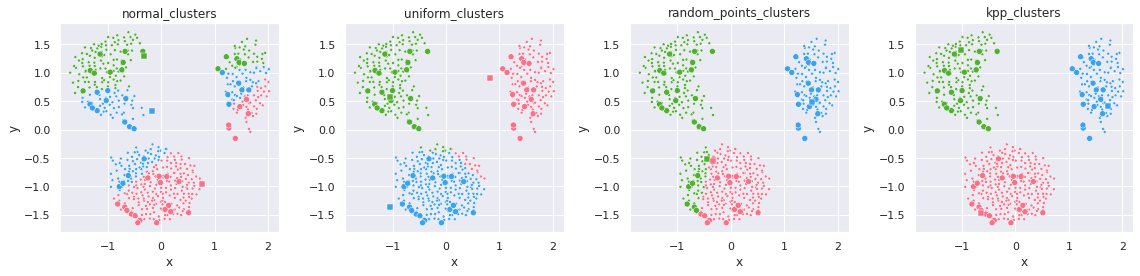

In [23]:
#@title How Initialization Affects The Solution

initializations = (normal_clusters,
                   uniform_clusters,
                   random_points_clusters,
                   kpp_clusters)

plt.figure(figsize=(16, 4))

for ix, ini in enumerate(initializations):
  c = ini(cluster_train, 3)
  p_tr = kmeans_predict(cluster_train, c)
  p_te = kmeans_predict(cluster_test, c)

  plt.subplot(1, len(initializations), ix+1)
  visualize_clusters(
    (cluster_train, p_tr, 'train', '.'),
    (cluster_test, p_te, 'test', 'o'),
    (c, [0, 1, 2], 'clusters', 's'),  # labels for clusters are trivial (0, 1, 2, ...)
    title=ini.__name__,
    legend=False,
    full=False
  )

plt.tight_layout();

The `normal_clusters` initialization procedure considers the mean and standard deviation of the training set's distribution, which means points drawn from this procedure will belong to the set's distribution and assume reasonable values in each feature.
For datasets with complex shapes (with holes close to its features' average values), this method might create unreasonable clusters, which lie on empty sections of the dimensional space. In the example above, we see clusters lying in between the data masses.

The `uniform` initialization behaves similarly to `random_clusters`, but it is ensured to always draw samples with feature values within their respective valid intervals.

On the other hand, `random_points_clusters` draws points from the training set itself, which will invariantly assume valid values in each feature, being valid cluster's centroid candidates. Its drawback lies on the uniform selection procedure itself: sampling datasets containing unbalanced masses will likely result in clusters being drawn from a same mass.

Finally, K-Means++ seems to already separate the data masses correctly from the start. K-Means will mearly move these points to their respective data masses' centroids.

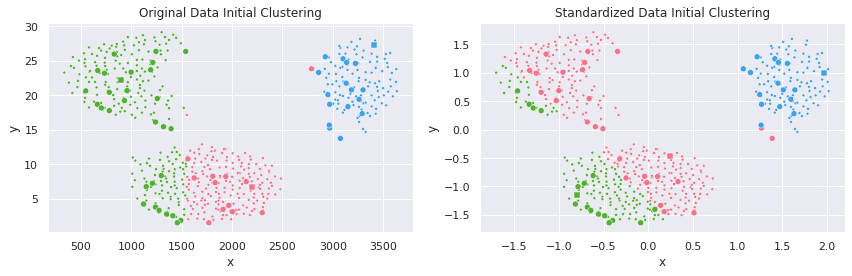

In [24]:
#@title How Standardization Affects The Solution

ctr = cluster_train * c_s + c_u
cte = cluster_test * c_s + c_u

c0 = kpp_clusters(ctr, 3)
c1 = kpp_clusters(cluster_train, 3)

p0_train = kmeans_predict(ctr, c0)
p0_test = kmeans_predict(cte, c0)

p1_train = kmeans_predict(cluster_train, c1)
p1_test = kmeans_predict(cluster_test, c1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
visualize_clusters(
  (ctr, p0_train, 'train', '.'),
  (cte, p0_test, 'test', 'o'),
  (c0, [0, 1, 2], 'clusters', 's'),         # labels for clusters are trivial (0, 1, 2, ...)
  title='Original Data Initial Clustering',
  full=False,
  legend=False
)

plt.subplot(122)
visualize_clusters(
  (cluster_train, p1_train, 'train', '.'),
  (cluster_test, p1_test, 'test', 'o'),
  (c1, [0, 1, 2], 'clusters', 's'),         # labels for clusters are trivial (0, 1, 2, ...)
  title='Standardized Data Initial Clustering',
  full=False,
  legend=False
)
plt.tight_layout();

del ctr, cte, c0, c1, p0_train, p0_test, p1_train, p1_test

Without standardization, samples are not correctly aggregated because of the different proportions of each axis.

In the example above, unstandardized feature $y$ ranged within the interval $[0, 30]$, and affected the $l^2$ distance much strongly than feature $x\in [250, 3750]$.
In the second scatterplot, we notice all features belonging to the same interval, and contributing similarly to the distance function $l^2$.

#### Application over The Cluster.dat Dataset

##### Searching K

In [25]:
%%time

report = kmeans_search(
  cluster_train,
  k_max=Config.cluster_dat.k_max,
  init=Config.cluster_dat.k_init_method,
  repeats=Config.cluster_dat.repeats,
  steps=Config.cluster_dat.steps,
  verbose=2
)

k: 2, performing 100 tests
....................................................................................................
k: 3, performing 100 tests
....................................................................................................
k: 4, performing 100 tests
....................................................................................................
k: 5, performing 100 tests
....................................................................................................
k: 6, performing 100 tests
....................................................................................................
k: 7, performing 100 tests
....................................................................................................
k: 8, performing 100 tests
....................................................................................................
k: 9, performing 100 tests
.............................................................................

In [26]:
report.groupby('k').mean().round(2).T

k,2,3,4,5,6,7,8,9,10
repetition,49.50,49.50,49.50,49.50,49.50,49.50,49.50,49.50,49.50
Loss,576.63,139.47,110.74,92.67,78.08,66.92,57.72,51.29,45.16
WCSS,1.12,0.27,0.21,0.18,0.15,0.13,0.11,0.10,0.09
BCSS,5.81,11.89,15.67,19.90,23.91,27.78,31.94,35.79,40.29
Silhouette,0.63,0.88,0.72,0.66,0.62,0.59,0.58,0.56,0.54
WC Silhouette,0.32,0.29,0.18,0.13,0.10,0.08,0.07,0.06,0.05


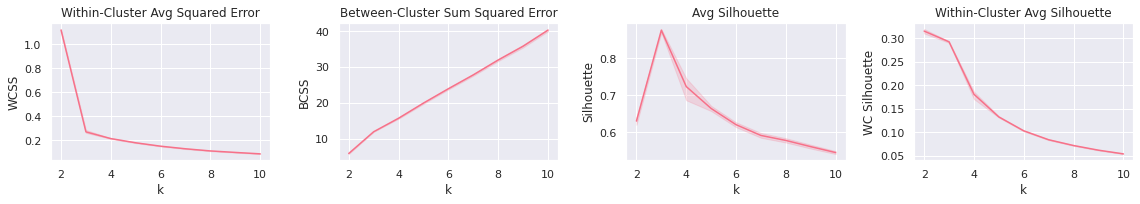

In [27]:
#@title

plt.figure(figsize=(16, 3))
plt.subplot(141).set_title('Within-Cluster Avg Squared Error'); sns.lineplot(data=report, x='k', y='WCSS')
plt.subplot(142).set_title('Between-Cluster Sum Squared Error'); sns.lineplot(data=report, x='k', y='BCSS')
plt.subplot(143).set_title('Avg Silhouette'); sns.lineplot(data=report, x='k', y='Silhouette')
plt.subplot(144).set_title('Within-Cluster Avg Silhouette'); sns.lineplot(data=report, x='k', y='WC Silhouette')
plt.tight_layout();

##### Training

In [28]:
best_k = report.groupby('k').mean().Silhouette.idxmax()

print(f'Best K (highest Silhouette) found: {best_k}')

Best K (highest Silhouette) found: 3


In [29]:
clusters = tf.Variable(normal_clusters(cluster_train, best_k), name=f'ck{best_k}')
clusters = kmeans_fit(
  cluster_train,
  clusters,
  steps=Config.cluster_dat.steps,
  tol=Config.cluster_dat.tol,
  verbose=2
)

Step 0
  Loss          =     558.8657
  WCSS          =       1.0831
  BCSS          =       6.2157
  Silhouette    =       0.7713
  WC Silhouette =       0.2571
  Samples       = [222 173 121]
Step 10
  Loss          =     136.3045
  WCSS          =       0.2642
  BCSS          =       11.542
  Silhouette    =       0.8801
  WC Silhouette =       0.2934
  Samples       = [252 151 113]
Step 20
  Loss          =     135.3605
  WCSS          =       0.2623
  BCSS          =      11.8651
  Silhouette    =       0.8801
  WC Silhouette =       0.2934
  Samples       = [252 151 113]

Early stopping as loss diff less than tol [0.0001 > 0.0001]
Step 28
  Loss          =     135.3554
  WCSS          =       0.2623
  BCSS          =      11.8861
  Silhouette    =       0.8801
  WC Silhouette =       0.2934
  Samples       = [252 151 113]


##### Evaluation

In [30]:
p_train = kmeans_predict(cluster_train, clusters)
p_test = kmeans_predict(cluster_test, clusters)
p_clusters = tf.range(best_k)  # clusters tags are trivial: [0, 1, 2, ...]

kmeans_report_evaluation('Train', cluster_train, clusters)
kmeans_report_evaluation('Test', cluster_test, clusters)

Train
  Loss          =     135.3554
  WCSS          =       0.2623
  BCSS          =      11.8861
  Silhouette    =       0.8801
  WC Silhouette =       0.2934
  Samples       = [252 151 113]
Test
  Loss          =      18.7536
  WCSS          =        0.329
  BCSS          =      11.8194
  Silhouette    =       0.8558
  WC Silhouette =       0.2853
  Samples       =   [22 18 17]


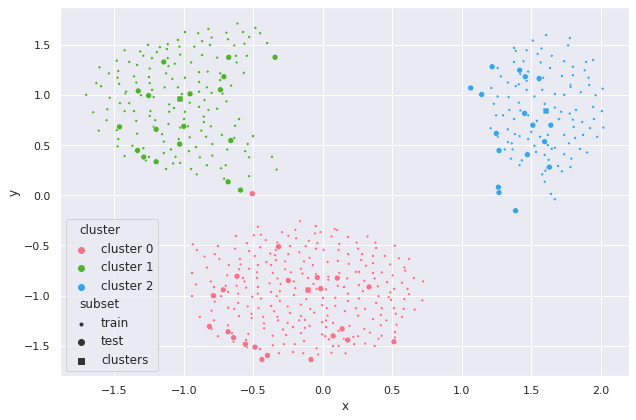

In [31]:
visualize_clusters(
  (cluster_train, p_train, 'train', '.'),
  (cluster_test, p_test, 'test', 'o'),
  (clusters, p_clusters, 'clusters', 's')
)

##### Discussions

The search strategy found the correct underlying structure of the data ($K=3$).
With it, K-Means was able to perfecly separate the data.
The centroids of the clusters are seemly positioned on the center of each data mass.

As the train-test subsets were split through random selection, the data distributions from these sets are fairly similar.
Therefore, the K-Means produced similar results for all metrics associated (WCSS, BCSS and Silhouette).

A few points from the test set stand out, being the fartherest from the centroid of their clusters (bottom samples of clusters 1 and 2).  For cluster 1, two samples are close to the decision boundary between cluster 0 and 1, in which each is assigned a different label.
As for cluster 2, the three outlying samples are still correctly labeled.
Further inspection --- and information around the problem domain --- is needed in order to verify if these samples are indeed exceptional cases or merely noise during the capturing procedure.

#### Application over The Boston Dataset

##### Searching K

In [32]:
%%time

report = kmeans_search(
  boston_x_train,
  k_max=Config.boston.k_max,
  steps=Config.boston.steps,
  repeats=Config.boston.repeats,
  verbose=2
)

k: 2, performing 100 tests
....................................................................................................
k: 3, performing 100 tests
....................................................................................................
k: 4, performing 100 tests
....................................................................................................
k: 5, performing 100 tests
....................................................................................................
k: 6, performing 100 tests
....................................................................................................
k: 7, performing 100 tests
....................................................................................................
k: 8, performing 100 tests
....................................................................................................
k: 9, performing 100 tests
.............................................................................

In [33]:
report.groupby('k').mean().round(2).T

k,2,3,4,5,6,7,8,9,10
repetition,49.50,49.50,49.50,49.50,49.50,49.50,49.50,49.50,49.50
Loss,3500.68,2905.68,2520.68,2264.23,2021.83,1859.80,1720.60,1610.38,1509.03
WCSS,7.68,6.37,5.53,4.97,4.43,4.08,3.77,3.53,3.31
BCSS,27.48,54.85,80.92,116.41,139.87,165.98,198.61,229.79,256.41
Silhouette,0.54,0.47,0.45,0.44,0.43,0.43,0.42,0.42,0.41
WC Silhouette,0.27,0.16,0.11,0.09,0.07,0.06,0.05,0.05,0.04


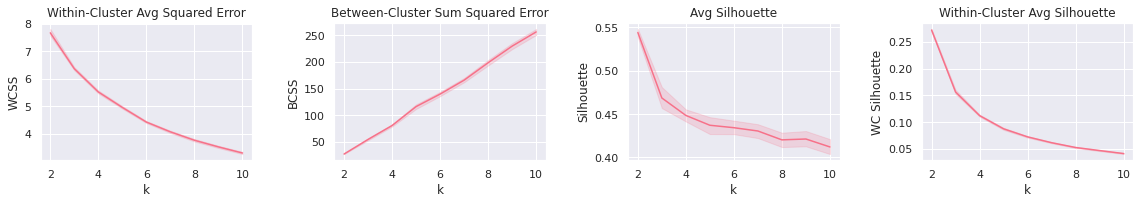

In [34]:
#@title

plt.figure(figsize=(16, 3))
plt.subplot(141).set_title('Within-Cluster Avg Squared Error'); sns.lineplot(data=report, x='k', y='WCSS')
plt.subplot(142).set_title('Between-Cluster Sum Squared Error'); sns.lineplot(data=report, x='k', y='BCSS')
plt.subplot(143).set_title('Avg Silhouette'); sns.lineplot(data=report, x='k', y='Silhouette')
plt.subplot(144).set_title('Within-Cluster Avg Silhouette'); sns.lineplot(data=report, x='k', y='WC Silhouette')
plt.tight_layout();

##### Training

Although the Avg. and Within-Cluster Avg. Silhouette curves point $k=2$ as the best (on average) parameter, WCSS and BCSS show that a large quantity of the system's total distance error could still be transfered from the within-distance component to the between-distance one by increasing the $k$ parameter.

We opted to define $K$ manually to 4, which results in a Silhouette decrease by almost 10%, while reducing the Within-Cluster Average Squared Error from 7.68 to 5.53.

In [35]:
best_k = 4  # report.groupby('k').mean().Silhouette.idxmax()

print(f'Manually selected K: {best_k}')

Manually selected K: 4


In [36]:
clusters = tf.Variable(normal_clusters(boston_x_train, best_k), name=f'ck{best_k}')
clusters = kmeans_fit(
  boston_x_train,
  clusters,
  steps=Config.boston.steps,
  tol=Config.boston.tol,
  report_every=25,
  verbose=2
)

Step 0
  Loss          =    7520.3135
  WCSS          =      16.4919
  BCSS          =      79.4723
  Silhouette    =       0.2172
  WC Silhouette =       0.0543
  Samples       = [269  35  63  89]
Step 25
  Loss          =    2595.8308
  WCSS          =       5.6926
  BCSS          =      72.2347
  Silhouette    =       0.4427
  WC Silhouette =       0.1107
  Samples       = [195  30 119 112]
Step 50
  Loss          =     2467.191
  WCSS          =       5.4105
  BCSS          =      75.8298
  Silhouette    =       0.4456
  WC Silhouette =       0.1114
  Samples       = [148  30 162 116]
Step 75
  Loss          =    2451.9692
  WCSS          =       5.3771
  BCSS          =      77.7814
  Silhouette    =       0.4542
  WC Silhouette =       0.1136
  Samples       = [127  30 183 116]
Step 100
  Loss          =    2445.6519
  WCSS          =       5.3633
  BCSS          =      78.1679
  Silhouette    =       0.4565
  WC Silhouette =       0.1141
  Samples       = [116  30 189 121]


##### Evaluation

In [37]:
p_train = kmeans_predict(boston_x_train, clusters)
p_test = kmeans_predict(boston_x_test, clusters)
p_clusters = tf.range(best_k)  # clusters tags are trivial: [0, 1, 2, ...]

kmeans_report_evaluation('Train', boston_x_train, clusters)
kmeans_report_evaluation('Test', boston_x_test, clusters)

Train
  Loss          =    2445.6519
  WCSS          =       5.3633
  BCSS          =      78.1679
  Silhouette    =       0.4565
  WC Silhouette =       0.1141
  Samples       = [116  30 189 121]
Test
  Loss          =     258.7456
  WCSS          =       5.1749
  BCSS          =      78.3563
  Silhouette    =       0.4684
  WC Silhouette =       0.1171
  Samples       = [15  4 17 14]


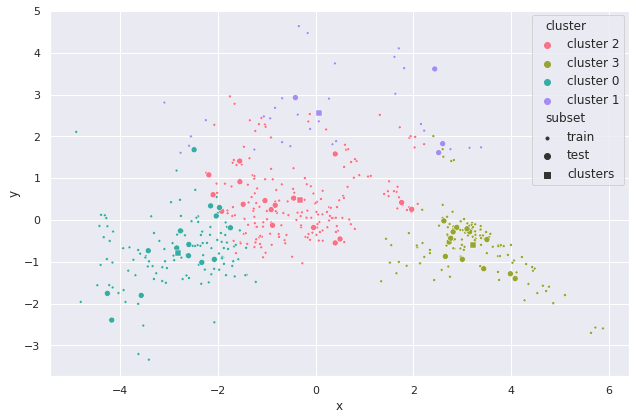

In [38]:
e = PCA(n_components=2)

visualize_clusters(
  (e.fit_transform(boston_x_train, p_train), p_train, 'train', '.'),
  (e.transform(boston_x_test), p_test, 'test', 'o'),
  (e.transform(clusters), p_clusters, 'clusters', 's')
)

##### Discussions

We are limited by the number of attributes that can be plotted at the same time in a scatterplot. Considering the Boston Dataset (as considered here) has 12 features, not all information is shown in the chart above.
We opted to use PCA as a visualization method to select the directions of most variability in the assignment of clusters and further improve the visualization.

We remark that this step is performed **after** K-Means execution, and therefore does not affect the results of the clustering method.

From the scatterplot above, we observe this set represents a much more complex structure than the Cluster.dat Dataset.
Clusters **0** and **2** are neighboring groups containing most samples from the set, where outliers from **3** are interlaced with other clusters.
Samples from the cluster **1** are sparsely distributed in the $12$-D space, not presenting the expected Gaussian sphere around its centroid.
Cluster **3** is more compact than **0** and **2**, and it is also the one that is most separated from the rest.

#### Application over The TF-Flowers Dataset

##### Preparing

In order to use K-Means, as implemented above, we transform our image dataset into a feature-vector dataset.
Furthermore, we "normalize" the samples features (pixels) by compressing their RGB values $[0, 256)$ into the $[-1, 1]$ interval.

In [39]:
def preprocess_input(x):
  x = tf.reshape(x, (-1, Config.tf_flowers.channels))
  x /= 127.5
  x -= 1
  return x

def postprocess_output(z):
  z += 1
  z *= 127.5
  z = tf.reshape(z, (-1, *Config.tf_flowers.shape))
  return z

##### Training

In [40]:
for flowers_train, _ in flowers_train_set.take(1):
  flowers_train = preprocess_input(flowers_train)  # (8, 150, 150, 3) -> (180,000, 3)

  s = tf.random.uniform([Config.tf_flowers.training_samples],
                        maxval=flowers_train.shape[0],
                        dtype=tf.int32)
  flowers_train_selected = tf.gather(flowers_train, s, axis=0)  # (10,000, 3)

In [41]:
clusters = tf.Variable(uniform_clusters(
  flowers_train,
  Config.tf_flowers.colors
))

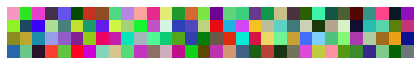

In [42]:
#@title Initial Color book

visualize_images(
  tf.reshape(tf.cast(127.5*(clusters + 1), tf.int32), (1, 4, -1, 3)),
  figsize=(6, 2),
  rows=1)

In [43]:
%%time

try: clusters = kmeans_fit(
       flowers_train_selected,
       clusters,
       steps=Config.tf_flowers.steps,
       tol=Config.tf_flowers.tol,
       verbose=2
      )
except KeyboardInterrupt: print('\ninterrupted')
else: print('done')

# Constrain to valid image pixel values.
clusters.assign(tf.clip_by_value(clusters, -1., 1.));

Step 0
  Loss          =     623.5992
  WCSS          =       0.0624
  BCSS          =     290.3632
  Silhouette    =      -0.9995
  WC Silhouette =      -0.0078
  Samples       = [275   0  17  27   0   9 477 272   0  24   8  18  93   0 116   0   0   0
   0   1   0   9 443  67   0   6 224 422   0  12 680   0   1   1   0   7
   2  44   0   0  51  27   0  95 574   0   3  50 324   0   0  73  67   2
   3 631 845 391 145   0   0   0  77  43 110  60   0  19   5   0  10   0
   5   0 216   0   0   3   0   0 331  80   0  19  74   0   6  37   1   0
   0  12  11  80  19   3   1   0 310  92   6   4   0   0  64   0   0 282
 278  15   0 369  17  28   8  16  18 283 157  53  52   9   6   4   0   2
   0 169]
Step 10
  Loss          =     227.3434
  WCSS          =       0.0227
  BCSS          =     290.3958
  Silhouette    =      -0.9995
  WC Silhouette =      -0.0078
  Samples       = [280   0  18 176   0 153 322 235   0   6   6  23  80   0  98   0   0   0
   0   2   0  24 459 119   0   4 255 178   0 

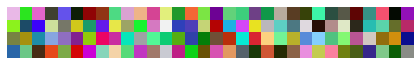

In [44]:
#@title Optimized Color Book

visualize_images(
  tf.reshape(tf.cast(127.5*(clusters + 1), tf.int32), (1, 4, -1, 3)),
  figsize=(6, 2),
  rows=1)

##### Transforming Images

In [45]:
for x, _ in flowers_test_set.take(3):
  # Encoding:
  y = kmeans_predict(preprocess_input(x), clusters)

  print(f'Encoding {x.shape[0]} images:')
  print(f'  shape: {x.shape} to {y.shape}')
  print(f'  size:  {size_in_mb(x):.2f} MB to {size_in_mb(y):.2f} MB')

  # Decoding:
  z = tf.gather(clusters, y, axis=0)
  z = postprocess_output(z)

  visualize_images([*tf.cast(x, tf.uint32), *tf.cast(z, tf.uint32)], figsize=(16, 4))

Output hidden; open in https://colab.research.google.com to view.

##### Discussions

Using this strategy, each $(150, 150, 3)$ image can be encoded into a $22500$-d vector.
Memory requirements for storing this information is reduced to 33.25\% (0.52 MB to 0.17 MB), plus the color code-book (global to the entire set).

Considering only the 24 test samples above, details seem to have been correctly preserved in all images.
Conversely, smooth sections of the images containing gradual color shift were most impacted by the compression process.

Efficacy could be improved by using more images from multiple batches.

### Hierarchical Clustering

We implemented the bottom-up strategy for Hierarchical Clustering.
This algorithm relies heavily on the greedy linkage between two shortest-distant clusters.

In order to efficiently perform this operation, a few assumptions are made:

- The distance between each pair of points in the set does not change after the algorithm starts. Hence the distance matrix is computed only once.
- Linkage between clusters `a` and `b` is the same as the linkage between `b` and `a`. I.e., linkage behaves as a distance function.
- The `heapq` module holds an efficient handling for heap/priority queues (which is true, considering our empirical results)

We start by implementing the `ClusterQueue` class.
When instantiated, an object of `ClusterQueue` receives as arguments a sample-wise distance matrix, a list of clusters (usually singletons) and a linkage function.
The heap `ClusterQueue#pq` is then built using each $\binom{|C|}{2}$ pair of clusters (and their linkage).
Two methods are now available: (1) `pop`, which retrieves the two closest clusters (according to their linkage) and (2) `merge`, which takes two clusters as arguments, merge them and add them to the heap.

During testing, the linkage between each sample in the test set is computed to each cluster in the training set, resulting in a cluster assignment (label) for each test sample.

#### Algorithm

In [46]:
import heapq


class ClusterQueue:
  """Priority Queue for sets of points (clusters).

  Arguments
  ---------
  distance: np.ndarray
    distance matrix between each pair of samples in the training data
  
  clusters: list of list of ints
    Starting configuration of clusters.
    Generally starts with singletons [[0], [1], [2], ...]
  
  linkage: str
    Linkage function used when computing distance between two clusters.

  """

  def __init__(self, distances, clusters, linkage):
    self.d = distances
    self.clusters = clusters
    self.linkage = get_linkage_by_name(linkage)

    self.build()

  def build(self):
    """Builds the priority queue containing elements (dist(a, b), a, b).
    """
    pq = []

    for i, a in enumerate(self.clusters):
      for j in range(i+1, len(self.clusters)):
        b = self.clusters[j]
        d_ab = self.linkage(self.d[a][:, b])
        pq.append((d_ab, a, b))

    heapq.heapify(pq)
    self.pq = pq
  
  def pop(self):
    # Invalid links (between old clusters) might exist as we merge 
    # and create new clusters. Continue until we find a valid one.
    while True:
      d, a, b = heapq.heappop(self.pq)
      
      if a in self.clusters and b in self.clusters:
        return d, a, b
  
  def merge(self, a, b):
    # Removes `a` and `b` from `clusters`, adds the distances
    # `d(c, o), for all o in clusters` to the priority queue.
    # Finally, adds a new set `c=a+b`.
    self.clusters.remove(a)
    self.clusters.remove(b)

    c = a + b

    for o in self.clusters:
      d_co = self.linkage(self.d[c][:, o])
      heapq.heappush(self.pq, (d_co, c, o))

    self.clusters.append(c)

In [47]:
from scipy.spatial.distance import cdist


def hierarchical_clustering(
    x: np.ndarray,
    metric: str = 'euclidean',
    linkage: str = 'average',
    max_e: float = None,
    min_k: int = 2,
    max_steps: int = None,
    verbose: int = 1,
    report_every: int = 50
) -> List[List[int]]:
  """Hierarchical Clustering.

  Arguments
  ---------
  x: np.ndarray
    Training data.
  metric: str
    Passed to `scipy.spatial.distance.cdist`. Metric used when computing
    distances between each pair of samples. Options are:
      braycurtis, canberra, chebyshev, cityblock, correlation,
      cosine, dice, euclidean, hamming, jaccard, jensenshannon,
      kulsinski, mahalanobis, matching, minkowski, rogerstanimoto,
      russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean,
      wminkowski, yule
  linkage: Callable
    Cluster linkage strategy. Options are:
      average, single, complete
  max_e: float
    Maximum linkage that is still considered as "close". Early stopping threshold.
  min_k: int
    Minimum number of clusters before stopping. Early stopping threshold.
  max_steps: int
    Maximum number of iterations allowed. early stopping threshold.
  verbosity:
    Controls the process verbosity. Options are 0, 1 or 2.
  report_every:
    Controls how frequently evaluation is performed.

  Returns
  -------
  List of set of point indices.
    A list containing the clustered points found.
    Each element of the list is a set of indices for the first axis of the training data:

    x := [[x00, x01, x02, ...],
          [x10, x11, x12, ...],
          ... ]

    hierarchical_clustering(x, ...)
      := [[0, 4, 5], [1, 2, 6], [3, 7, 10], ...]
  """
  cq = ClusterQueue(distances=cdist(x, x, metric=metric),
                    clusters=[[i] for i in range(len(x))],
                    linkage=linkage)
  step = 1

  while len(cq.clusters) > 1:
    d_ab, a, b = cq.pop()

    if verbose > 1 and step % report_every == 0:
      hc_report_evaluation(f'Step {step}', x, x, cq.clusters, metric, linkage, d=cq.d)

    if max_e and d_ab > max_e:
      if verbose: print(f'\nEarly stopping: shortest linkage > max_e [{d_ab:.4f} > {max_e:.4f}]')
      break
    if len(cq.clusters) <= min_k:
      if verbose: print(f'\nEarly stopping: k <= min_k [{len(cq.clusters)} <= {min_k}]')
      break
    if max_steps and step >= max_steps:
      if verbose: print(f'\nEarly stopping: steps >= max_steps set [{step} >= {max_steps}]')
      break
    
    cq.merge(a, b)
    step += 1
  
  if verbose == 1 or verbose > 1 and step % report_every:
    # last step, if not reported yet.
    hc_report_evaluation(f'Step {step}', x, x, cq.clusters, metric, linkage, d=cq.d)

  return cq.clusters


def hc_report_evaluation(tag, s, x, clusters, metric, linkage, d=None):
  report = hc_test_step(s, x, clusters, metric, linkage, d=d)
  
  print(tag)
  lpad = max(map(len, report)) + 2
  rpad = 12

  for metric, value in report.items():
    print(f'  {metric}'.ljust(lpad), '=', str(np.round(value, 4)).rjust(rpad))


def hc_test_step(
    s: np.asarray,
    x: np.asarray,
    clusters: List[List[int]],
    metric: str = 'euclidean',
    linkage: str = 'average',
    d: np.asarray = None
) -> Dict[str, float]:
  if d is None:  # Reuse distance matrix if it was already computed.
    d = cdist(s, x, metric=metric)

  linkage = get_linkage_by_name(linkage)
  
  # Samples in the training set `x` have trivial labels.
  yx = np.zeros(len(x))
  for ix, c in enumerate(clusters): yx[c] = ix

  # Calculate labels in sample set `s`.
  ys = [linkage(d[:, c], axis=1) for c in clusters]
  ys = np.argmin(ys, axis=0)

  samples = HCMetrics.samples_per_cluster(ys)
  wss_ = HCMetrics.WCSS(d, ys, yx, linkage)
  bss_ = HCMetrics.BCSS(d, ys, yx, linkage)
  sil_ = HCMetrics.silhouette(d, ys, yx, linkage)
  wc_sil_ = HCMetrics.wc_avg_silhouette(d, ys, yx, linkage)

  return dict(zip(
    ('Loss', 'WCSS', 'BCSS', 'Silhouette', 'WC Silhouette', 'Clusters', 'Samples'),
    (np.sum(np.concatenate(wss_)),
     np.mean(np.concatenate(wss_)),
     np.mean(np.concatenate(bss_)),
     np.mean(sil_),
     np.mean(wc_sil_),
     len(clusters),
     samples[:10])
  ))

In [48]:
def hc_search(
  x: np.ndarray,
  params: Union[List[Dict[str, Any]], ParameterGrid],
  max_steps: int = None,
  verbose: int = 1,
) -> pd.DataFrame:
  """Search for Hyper-Parameter Optimization.

  Returns
  -------
    pd.DataFrame
      The search results report.
  """
  results = []
  
  for ix, p in enumerate(params):
    if verbose > 0: print(f'params: {p}')

    clusters = hierarchical_clustering(x, max_steps=max_steps, verbose=0, **p)
    metrics = hc_test_step(x, x, clusters, p['metric'], p['linkage'])
    results += [{'config_id': ix, 'params': p, **metrics}]

  return pd.DataFrame(results)

In [49]:
def hc_predict(
  s: np.ndarray,
  x: np.ndarray,
  clusters: List[List[int]],
  metric: str = 'euclidean',
  linkage: str = 'average',
) -> np.array:
  """Hierarchical Clustering Predict.

  Predict new samples based on minimal distance to existing clusters,
  without altering their current configuration.

  """
  d = cdist(s, x, metric=metric)
  linkage = get_linkage_by_name(linkage)

  # We need a label for every single point, so we calculate
  # single point-to-cluster distance (hence axis=1).
  l = [linkage(d[:, c], axis=1) for c in clusters]
  l = np.argmin(l, axis=0)

  return l

#### Linkage and Evaluation Metrics

In [50]:
def single_linkage(d, axis=None):
  return np.min(d, axis=axis)

def average_linkage(d, axis=None):
  return np.mean(d, axis=axis)

def complete_linkage(d, axis=None):
  return np.max(d, axis=axis)


def get_linkage_by_name(name):
  return globals()[f'{name}_linkage']


# Metrics

class HCMetrics:
  @staticmethod
  def WCSS(d, yx, yc, linkage, reducer=None):
    return [linkage(d[yx == label][:, yc == label], axis=1) for label in np.unique(yx)]
  
  @staticmethod
  def BCSS(d, yx, yc, linkage, reducer=np.concatenate):
    return [linkage(d[yx == label][:, yc != label], axis=1) for label in np.unique(yx)]
  
  @staticmethod
  def silhouette(d, yx, yc, linkage):
    a = np.concatenate(HCMetrics.WCSS(d, yx, yc, linkage))
    b = np.concatenate(HCMetrics.BCSS(d, yx, yc, linkage))

    return (b - a) / np.maximum(a, b)

  @staticmethod
  def wc_avg_silhouette(d, yx, yc, linkage):
    # WCSS and BCSS return tensors in the shape (clusters, samples),
    # so we can simply zip them together:
    return np.asarray([
      np.mean((b-a) / np.maximum(a, b))
      for a, b in zip(HCMetrics.WCSS(d, yx, yc, linkage),
                      HCMetrics.BCSS(d, yx, yc, linkage))
    ])

  @staticmethod
  def samples_per_cluster(yx):
    return np.unique(yx, return_counts=True)[1]

#### Application over The Cluster.dat Dataset

##### Searching

In [51]:
%%time

report = hc_search(
  cluster_train.numpy(),
  params=ParameterGrid({
    'metric': ['euclidean'],    # ... 'correlation'] --- different metrics aren't directly comparable.
    'linkage': ['average'],   # ... 'average', 'complete'] --- different linkages aren't directly comparable.
    'max_e': [.4, .5, .6, .7, .8, .9, 1.],
    'min_k': [3]
  }),
  max_steps=1000,
  verbose=1
)

params: {'linkage': 'average', 'max_e': 0.4, 'metric': 'euclidean', 'min_k': 3}
params: {'linkage': 'average', 'max_e': 0.5, 'metric': 'euclidean', 'min_k': 3}
params: {'linkage': 'average', 'max_e': 0.6, 'metric': 'euclidean', 'min_k': 3}
params: {'linkage': 'average', 'max_e': 0.7, 'metric': 'euclidean', 'min_k': 3}
params: {'linkage': 'average', 'max_e': 0.8, 'metric': 'euclidean', 'min_k': 3}
params: {'linkage': 'average', 'max_e': 0.9, 'metric': 'euclidean', 'min_k': 3}
params: {'linkage': 'average', 'max_e': 1.0, 'metric': 'euclidean', 'min_k': 3}
CPU times: user 38.9 s, sys: 261 ms, total: 39.1 s
Wall time: 39 s


In [52]:
report

,config_id,params,Loss,WCSS,BCSS,Silhouette,WC Silhouette,Clusters,Samples
0,0,"{'linkage': 'average', 'max_e': 0.4, 'metric':...",123.149075,0.238661,1.832141,0.866961,0.868972,22,"[18, 21, 19, 17, 12, 26, 26, 24, 15, 26]"
1,1,"{'linkage': 'average', 'max_e': 0.5, 'metric':...",172.522433,0.334346,1.900845,0.819848,0.824206,12,"[23, 35, 51, 29, 32, 47, 27, 60, 59, 40]"
2,2,"{'linkage': 'average', 'max_e': 0.6, 'metric':...",188.875987,0.366039,1.923056,0.804530,0.809369,10,"[27, 34, 47, 72, 59, 44, 69, 54, 64, 46]"
3,3,"{'linkage': 'average', 'max_e': 0.7, 'metric':...",210.212608,0.407389,1.955571,0.784737,0.794780,8,"[35, 88, 59, 56, 54, 73, 60, 91]"
4,4,"{'linkage': 'average', 'max_e': 0.8, 'metric':...",271.661438,0.526476,2.096086,0.741569,0.751672,5,"[48, 121, 131, 113, 103]"
5,5,"{'linkage': 'average', 'max_e': 0.9, 'metric':...",333.998196,0.647283,2.387472,0.722905,0.732815,3,"[113, 252, 151]"
6,6,"{'linkage': 'average', 'max_e': 1.0, 'metric':...",333.998196,0.647283,2.387472,0.722905,0.732815,3,"[113, 252, 151]"


##### Training

In [53]:
best_params = dict(
  metric='euclidean',
  linkage='average',
  max_e=.9,
)

In [54]:
%%time

clusters = hierarchical_clustering(
  cluster_train.numpy(),
  **best_params,
  max_steps=1000,
  report_every=250,
  verbose=2
)

Step 250
  Loss          =      17.0699
  WCSS          =       0.0331
  BCSS          =       1.7615
  Silhouette    =       0.9805
  WC Silhouette =       0.9852
  Clusters      =          267
  Samples       = [1 1 1 1 1 1 1 1 1 1]
Step 500
  Loss          =     143.1246
  WCSS          =       0.2774
  BCSS          =       1.8524
  Silhouette    =       0.8452
  WC Silhouette =       0.8511
  Clusters      =           17
  Samples       = [16 26 30 26 35 35 28 30 35 25]

Early stopping: shortest linkage > max_e [2.1811 > 0.9000]
Step 514
  Loss          =     333.9982
  WCSS          =       0.6473
  BCSS          =       2.3875
  Silhouette    =       0.7229
  WC Silhouette =       0.7328
  Clusters      =            3
  Samples       = [113 252 151]
CPU times: user 5.98 s, sys: 69.1 ms, total: 6.05 s
Wall time: 6.02 s


##### Evaluate

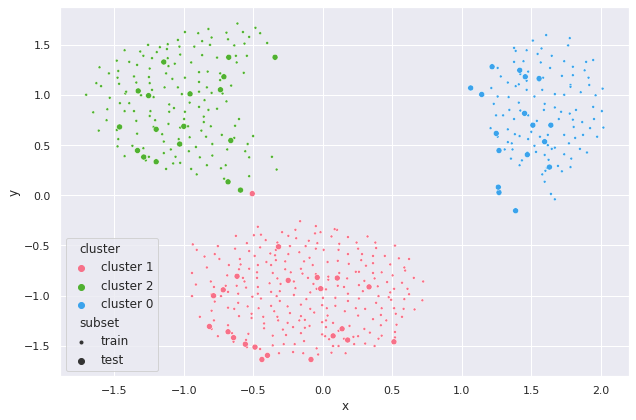

In [55]:
p_train = hc_predict(cluster_train.numpy(), cluster_train.numpy(), clusters, best_params['metric'], best_params['linkage'])
p_test = hc_predict(cluster_test.numpy(), cluster_train.numpy(), clusters, best_params['metric'], best_params['linkage'])

visualize_clusters(
  (cluster_train, p_train, 'train', '.'),
  (cluster_test, p_test, 'test', 'o'),
)

##### Discussions

We assume multiple distances and linkages are not directly comparable, considering their differences in construction. For example, single linkage will always return lower values than average and complete linkage.
Therefore, we only searched within a single combination of metric and linkage.

For Hierarchical Clustering, WCSS is minimal when all clusters are singleton, and will increase as the algorithm progresses. BCSS also increases as samples in the set are aggregated into fewer clusters, as their centroids become increasingly more distant from each other. 
Furthermore, as the within cluster linkage tends to `0`, `max(a, b)` tends to `b`, and the Silhouette tends to 1. As the algorithm executes, increasing `a`, the Avg. Silhouette decreases.

We were limited to search for the `max_e` and `min_k` parameters. As these are early stopping arguments and will dictate for how many iterations the algorithm will run, it becomes clear that larger `max_e`/lower `min_k` will always result in lower `Avg. Silhouette` values.
Therefore, we selected the winning searching arguments based on how many clusters they would produce, as well as the amount of samples in each cluster.

The Cluster.dat Dataset was once again easily clustered using $e=0.9$.
The algorithm early stopped with the min distance threshold ($min(d) = 2.1811 > e=0.9$), and have correctly found the 3 clusters for the set.

#### Application over The Boston Dataset

##### Searching

In [56]:
%%time

report = hc_search(
  boston_x_train.numpy(),
  params=ParameterGrid({
    'metric': ['euclidean'],
    'linkage': ['average'],
    'max_e': [3., 4., 5., 6.],
  }),
  max_steps=1000,
  verbose=1
)

params: {'linkage': 'average', 'max_e': 3.0, 'metric': 'euclidean'}
params: {'linkage': 'average', 'max_e': 4.0, 'metric': 'euclidean'}
params: {'linkage': 'average', 'max_e': 5.0, 'metric': 'euclidean'}
params: {'linkage': 'average', 'max_e': 6.0, 'metric': 'euclidean'}
CPU times: user 18.4 s, sys: 130 ms, total: 18.5 s
Wall time: 18.4 s


In [57]:
report

,config_id,params,Loss,WCSS,BCSS,Silhouette,WC Silhouette,Clusters,Samples
0,0,"{'linkage': 'average', 'max_e': 3.0, 'metric':...",845.158726,1.853418,4.920494,0.610357,0.731290,27,"[3, 1, 1, 1, 3, 2, 2, 2, 3, 19]"
1,1,"{'linkage': 'average', 'max_e': 4.0, 'metric':...",1117.561158,2.450792,5.196285,0.518607,0.591593,13,"[1, 7, 9, 10, 3, 47, 98, 179, 18, 28]"
2,2,"{'linkage': 'average', 'max_e': 5.0, 'metric':...",1462.803239,3.207902,5.561461,0.414422,0.452314,5,"[15, 6, 148, 261, 26]"
3,3,"{'linkage': 'average', 'max_e': 6.0, 'metric':...",1947.314461,4.270426,7.942562,0.446827,0.351500,3,"[35, 18, 403]"


##### Training

In [58]:
best_params = dict(
  metric='euclidean',
  linkage='average',
  max_e=5.
)

In [59]:
%%time

clusters = hierarchical_clustering(
  boston_x_train.numpy(),
  **best_params,
  max_steps=1000,
  report_every=100,
  verbose=2
)

Step 100
  Loss          =      38.1231
  WCSS          =       0.0836
  BCSS          =       4.5458
  Silhouette    =       0.9804
  WC Silhouette =       0.9902
  Clusters      =          357
  Samples       = [1 1 1 1 1 1 1 1 1 1]
Step 200
  Loss          =     113.9365
  WCSS          =       0.2499
  BCSS          =       4.5562
  Silhouette    =       0.9415
  WC Silhouette =       0.9683
  Clusters      =          257
  Samples       = [1 1 1 1 1 1 1 1 1 1]
Step 300
  Loss          =     244.6256
  WCSS          =       0.5365
  BCSS          =       4.5774
  Silhouette    =       0.8755
  WC Silhouette =       0.9226
  Clusters      =          157
  Samples       = [1 1 1 1 1 1 1 1 1 1]
Step 400
  Loss          =     563.1001
  WCSS          =       1.2349
  BCSS          =        4.695
  Silhouette    =       0.7234
  WC Silhouette =       0.8217
  Clusters      =           57
  Samples       = [1 1 1 1 1 6 1 1 1 1]

Early stopping: shortest linkage > max_e [5.3871 > 5.0000]


##### Evaluate

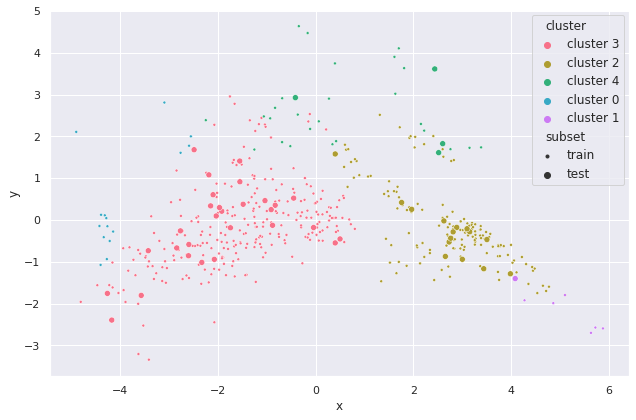

In [60]:
e = PCA(n_components=2)

p_train = hc_predict(boston_x_train.numpy(), boston_x_train.numpy(), clusters, best_params['metric'], best_params['linkage'])
p_test = hc_predict(boston_x_test.numpy(), boston_x_train.numpy(), clusters, best_params['metric'], best_params['linkage'])

visualize_clusters(
  (e.fit_transform(boston_x_train, p_train), p_train, 'train', '.'),
  (e.transform(boston_x_test), p_test, 'test', 'o'),
)

##### Discussions

We selected $e=5.0$, as this configuration resulted in 5 clusters more evenly balanced, with three seemly containing outliers. Greater values for $e$ resulted in a single main cluster being found, and two more containing few outlying samples.

The neighboring clusters found by K-Means have disapeared here. Furthermore, sparsely outlying samples have been clustered into small subsets (comprising of few samples).
This confirms the search results found when applying the K-Means algorithm, which described this set as being dominated by two large clusters ($k=2$).

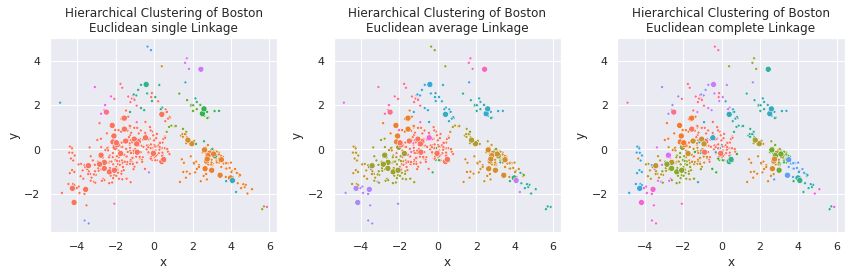

In [61]:
#@title Difference Between Linkages

e = PCA(n_components=2)

z_train = e.fit_transform(boston_x_train)
z_test = e.transform(boston_x_test)

linkages = ('single', 'average', 'complete')
results = []


for linkage in linkages:
  clusters = hierarchical_clustering(
    boston_x_train.numpy(),
    metric='euclidean',
    linkage=linkage,
    max_e=4.,
    min_k=25,
    max_steps=1000,
    verbose=0)

  p_train = hc_predict(
    boston_x_train.numpy(),
    boston_x_train.numpy(),
    clusters,
    metric='euclidean',
    linkage=linkage)
  p_test = hc_predict(
    boston_x_test.numpy(),
    boston_x_train.numpy(),
    clusters,
    metric='euclidean',
    linkage=linkage)
  
  results += [(p_train, p_test)]


plt.figure(figsize=(12, 4))
for ix, (linkage, (p_train, p_test)) in enumerate(zip(linkages, results)):
  plt.subplot(1, 3, ix+1)
  visualize_clusters(
    (z_train, p_train, 'train', '.'),
    (z_test, p_test, 'test', 'o'),
    title=f'Hierarchical Clustering of Boston\nEuclidean {linkage} Linkage',
    full=False,
    legend=False
  )
  
plt.tight_layout()

Single linkage is capable of finding non-linear relationships, where clusters are associated by their closest link, so non-spherical shaped clusters might appear (such as the pink one in the first plot). A downside of this linkage is the possible construction of unbalance clusters when data density varies across the space.
This behavior can be observed in the Boston Dataset, were samples in the left-center are closely positioned, in opposite of the few samples on the right-bottom.

Complete linkage favors concise clusters in opposite of large ones, in which all samples are closely related. We observed for this example that the large data mass in the left-center was subdivided into multiple different clusters.

Average linkage seems as a compromise between Single and Complete linkage, pondering between cluster central similarity and sample conciseness.

## Part-2: Dimensionality Reduction

**How/if normalization affected our results**

For a dataset $X$, where each feature is centered in $0$, Principal Component Analysis (PCA) can be expressed as the Singular Value Decomposition of the covariance matrix $XX^\intercal$ (which has the same sigular components as the matrix $X$).
In a set of many features within different intervals, some features present larger variance intervals than others.
In such cases, the sigular components will focus on modeling these directions, as their composition represent the highest total variance of the set.
While this is interesting in many analytical cases, it is usually an unwanted behavior in Machine Learning: features should be favored based on how well they explain the overall data, independently of their natural variance.

A second formulation of the PCA can then be defined over the correlation matrix $\frac{XX^\intercal}{\sigma(X)^2}$. In this form, all features will vary in the same interval ($\mu_X=0, \sigma =1$), and the singular components will exclusevely model the relationship between the variables.
An easy way to achieve this form is to simply standardize the data (dividing each column by its standard deviation) before applying PCA. The new set will have $\sigma(X')=1$ and its covariance and correlation matrices will be the same. The two scatterplots below show the difference between the two formulations on the Boston Dataset.

For the purposes of this assignment, all our PCA runs are based on the decomposition of the correlation matrix.

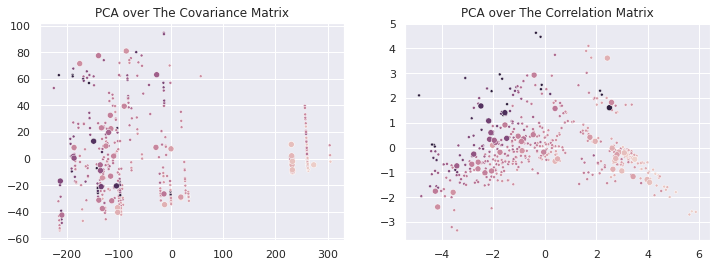

In [62]:
#@title

from sklearn.decomposition import PCA

e = PCA(n_components=2)

b_cov_train = e.fit_transform(inverse_standardize(boston_x_train, b_u, b_s))
b_cov_test = e.transform(inverse_standardize(boston_x_test, b_u, b_s))

b_cor_train = e.fit_transform(boston_x_train)
b_cor_test = e.transform(boston_x_test)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('PCA over The Covariance Matrix')
sns.scatterplot(x=b_cov_train[:, 0], y=b_cov_train[:, 1], hue=boston_y_train, marker='.', label='train', legend=False)
sns.scatterplot(x=b_cov_test[:, 0], y=b_cov_test[:, 1], hue=boston_y_test, label='test', legend=False)

plt.subplot(122)
plt.title('PCA over The Correlation Matrix')
sns.scatterplot(x=b_cor_train[:, 0], y=b_cor_train[:, 1], hue=boston_y_train, marker='.', label='train', legend=False)
sns.scatterplot(x=b_cor_test[:, 0], y=b_cor_test[:, 1], hue=boston_y_test, label='test', legend=False)


del e, b_cov_train, b_cov_test, b_cor_train, b_cor_test

### K-Means

#### Application over The Boston Dataset

In [63]:
energies = [0.5, .85, .9, .95, .99, .999]

In [64]:
reductions = []

print(f'Data dimensionality: {boston_x_train.shape[1]}')

for energy in energies:
  e = PCA(n_components=energy)
  tr = e.fit_transform(boston_x_train)
  te = e.transform(boston_x_test)

  tr = tf.convert_to_tensor(tr, tf.float32)
  te = tf.convert_to_tensor(te, tf.float32)

  reductions.append((tr, te))
  
  print(f'Components used to explain e={energy:.0%}: {e.n_components_}')

Data dimensionality: 12
Components used to explain e=50%: 2
Components used to explain e=85%: 6
Components used to explain e=90%: 7
Components used to explain e=95%: 9
Components used to explain e=99%: 11
Components used to explain e=100%: 12


##### Searching K

In [65]:
%%time

report = pd.concat([
  kmeans_search(
    b,
    k_max=Config.boston.k_max,
    steps=Config.boston.steps,
    repeats=Config.boston.repeats,
    verbose=0
  ).assign(energy=e)
  for e, (b, _) in zip(energies, reductions)
])

CPU times: user 37min 11s, sys: 1min 29s, total: 38min 41s
Wall time: 31min 32s


In [66]:
report.groupby('energy').mean().round(2).T

energy,0.500,0.850,0.900,0.950,0.990,0.999
k,6.00,6.00,6.00,6.00,6.00,6.00
repetition,49.50,49.50,49.50,49.50,49.50,49.50
Loss,567.96,1645.48,1813.70,2014.05,2193.21,2222.05
WCSS,1.25,3.61,3.98,4.42,4.81,4.87
BCSS,91.49,133.26,135.88,139.59,141.09,140.37
Silhouette,0.60,0.51,0.48,0.47,0.45,0.44
WC Silhouette,0.13,0.11,0.11,0.10,0.10,0.10


In [67]:
report.groupby('k').mean().round(2).T

k,2,3,4,5,6,7,8,9,10
repetition,49.50,49.50,49.50,49.50,49.50,49.50,49.50,49.50,49.50
Loss,2974.80,2366.72,2019.35,1754.76,1560.49,1413.39,1284.29,1192.76,1118.10
WCSS,6.52,5.19,4.43,3.85,3.42,3.10,2.82,2.62,2.45
BCSS,26.07,51.89,78.47,103.13,130.02,155.11,181.85,209.93,236.07
Silhouette,0.58,0.51,0.49,0.48,0.48,0.47,0.47,0.47,0.46
WC Silhouette,0.29,0.17,0.12,0.10,0.08,0.07,0.06,0.05,0.05
energy,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86


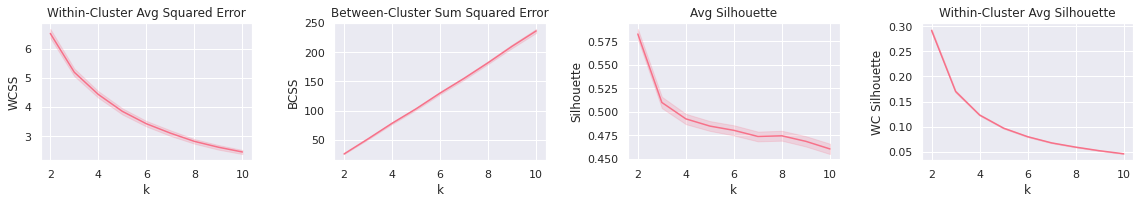

In [68]:
#@title

plt.figure(figsize=(16, 3))
plt.subplot(141).set_title('Within-Cluster Avg Squared Error'); sns.lineplot(data=report, x='k', y='WCSS')
plt.subplot(142).set_title('Between-Cluster Sum Squared Error'); sns.lineplot(data=report, x='k', y='BCSS')
plt.subplot(143).set_title('Avg Silhouette'); sns.lineplot(data=report, x='k', y='Silhouette')
plt.subplot(144).set_title('Within-Cluster Avg Silhouette'); sns.lineplot(data=report, x='k', y='WC Silhouette')
plt.tight_layout();

##### Training

In [69]:
best_e = 4  # report.groupby('energy').mean().Silhouette.argmax()
best_k = 4  # report.groupby('k').mean().Silhouette.idxmax()

boston_z_train, boston_z_test = reductions[best_e]

print(f'Manually selected energy: {energies[best_e]}')
print(f'Manually selected K (low WCSS, high Silhouette) found: {best_k}')

Manually selected energy: 0.99
Manually selected K (low WCSS, high Silhouette) found: 4


In [70]:
clusters = tf.Variable(normal_clusters(boston_z_train, best_k), name=f'ck{best_k}')
clusters = kmeans_fit(
  boston_z_train,
  clusters,
  steps=Config.boston.steps,
  verbose=2,
  report_every=25
)

Step 0
  Loss          =    4470.3965
  WCSS          =       9.8035
  BCSS          =       70.015
  Silhouette    =       0.3125
  WC Silhouette =       0.0781
  Samples       = [233  53  95  75]
Step 25
  Loss          =    2488.5215
  WCSS          =       5.4573
  BCSS          =      71.1669
  Silhouette    =        0.452
  WC Silhouette =        0.113
  Samples       = [203  56  82 115]
Step 50
  Loss          =    2430.7744
  WCSS          =       5.3306
  BCSS          =      73.9611
  Silhouette    =       0.4564
  WC Silhouette =       0.1141
  Samples       = [201  61  80 114]
Step 75
  Loss          =    2425.6655
  WCSS          =       5.3194
  BCSS          =      74.0592
  Silhouette    =        0.455
  WC Silhouette =       0.1138
  Samples       = [201  58  80 117]

Early stopping as loss diff less than tol [0.0000 > 0.0001]
Step 89
  Loss          =     2425.644
  WCSS          =       5.3194
  BCSS          =      74.0782
  Silhouette    =        0.455
  WC Silhoue

##### Evaluation

In [71]:
p_train = kmeans_predict(boston_z_train, clusters)
p_test = kmeans_predict(boston_z_test, clusters)
p_clusters = tf.range(best_k)  # clusters tags are trivial: [0, 1, 2, ...]

kmeans_report_evaluation('Train', boston_z_train, clusters)
kmeans_report_evaluation('Test', boston_z_test, clusters)

Train
  Loss          =     2425.644
  WCSS          =       5.3194
  BCSS          =      74.0782
  Silhouette    =        0.455
  WC Silhouette =       0.1138
  Samples       = [201  58  80 117]
Test
  Loss          =      254.467
  WCSS          =       5.0893
  BCSS          =       74.294
  Silhouette    =       0.4617
  WC Silhouette =       0.1154
  Samples       = [20  6  9 15]


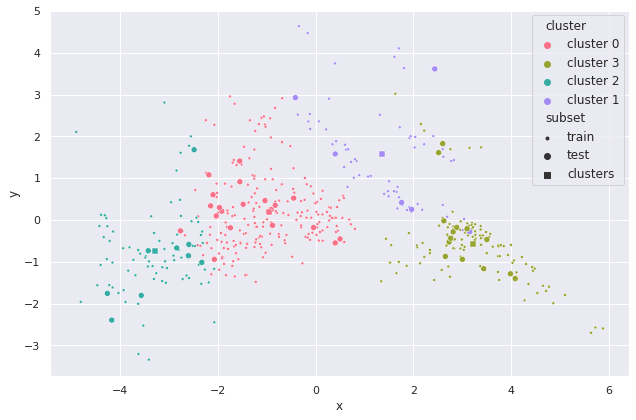

In [72]:
visualize_clusters(
  (boston_z_train, p_train, 'train', '.'),
  (boston_z_test, p_test, 'test', 'o'),
  (clusters, p_clusters, 'clusters', 's')
)

##### Discussions

We do not see the curse of dimensionality in this set. In fact, as this set has been highly curated, all of its columns represent complementary information and it is impossible to reduce dimensionality without loosing some residual information.
Notwithstanding, we have found that dimensionality reduction is still helpful in this case for removing noise and normalizing correlated (oval) data masses.

As PCA removes the least varying components (noise) from the data, samples become naturally closer from each other, reducing Within-Cluster distances. This can be observed in the search process, where the Silhouette curve increases as we reduce the energy retained by PCA.
However, this is an artificial improvement: samples which contained different measurements in the original space are being crunched together in the reduced one, in opposite of handling the curse of dimensionality.

### Hierarchical Clustering

#### Application over The Boston Dataset

##### Searching

In [73]:
%%time

report = hc_search(
  boston_z_train.numpy(),
  params=ParameterGrid({
    'metric': ['euclidean'],
    'linkage': ['average'],
    'max_e': [3., 4., 5., 6.],
  }),
  max_steps=1000,
  verbose=1
)

params: {'linkage': 'average', 'max_e': 3.0, 'metric': 'euclidean'}
params: {'linkage': 'average', 'max_e': 4.0, 'metric': 'euclidean'}
params: {'linkage': 'average', 'max_e': 5.0, 'metric': 'euclidean'}
params: {'linkage': 'average', 'max_e': 6.0, 'metric': 'euclidean'}
CPU times: user 18.8 s, sys: 144 ms, total: 18.9 s
Wall time: 18.9 s


In [74]:
report

,config_id,params,Loss,WCSS,BCSS,Silhouette,WC Silhouette,Clusters,Samples
0,0,"{'linkage': 'average', 'max_e': 3.0, 'metric':...",885.413789,1.941697,5.016328,0.601760,0.724130,25,"[2, 1, 1, 1, 7, 7, 3, 2, 3, 5]"
1,1,"{'linkage': 'average', 'max_e': 4.0, 'metric':...",1148.176471,2.517931,5.192029,0.507432,0.627608,10,"[1, 10, 3, 98, 18, 6, 71, 46, 6, 197]"
2,2,"{'linkage': 'average', 'max_e': 5.0, 'metric':...",1453.954900,3.188498,5.548425,0.416462,0.453209,5,"[15, 6, 261, 148, 26]"
3,3,"{'linkage': 'average', 'max_e': 6.0, 'metric':...",1940.056698,4.254510,7.935511,0.448238,0.351945,3,"[35, 18, 403]"


##### Training

In [75]:
%%time

clusters = hierarchical_clustering(
  boston_z_train.numpy(),
  metric='euclidean',
  linkage='average',
  max_e=5.,
  max_steps=1000,
  report_every=100,
  verbose=2)

Step 100
  Loss          =      38.0448
  WCSS          =       0.0834
  BCSS          =       4.5296
  Silhouette    =       0.9803
  WC Silhouette =       0.9902
  Clusters      =          357
  Samples       = [1 1 1 1 1 1 1 1 1 1]
Step 200
  Loss          =      112.793
  WCSS          =       0.2474
  BCSS          =       4.5397
  Silhouette    =       0.9419
  WC Silhouette =       0.9681
  Clusters      =          257
  Samples       = [1 1 1 1 1 1 1 1 1 1]
Step 300
  Loss          =     240.6055
  WCSS          =       0.5276
  BCSS          =       4.5603
  Silhouette    =       0.8775
  WC Silhouette =       0.9217
  Clusters      =          157
  Samples       = [1 1 1 1 1 1 1 1 1 1]
Step 400
  Loss          =     557.2534
  WCSS          =        1.222
  BCSS          =       4.6723
  Silhouette    =       0.7243
  WC Silhouette =       0.8259
  Clusters      =           57
  Samples       = [1 1 1 1 1 6 1 1 1 1]

Early stopping: shortest linkage > max_e [5.3724 > 5.0000]


##### Evaluating

In [76]:
p_train = hc_predict(
  boston_z_train.numpy(),
  boston_z_train.numpy(), clusters)
p_test = hc_predict(
  boston_z_test.numpy(),
  boston_z_train.numpy(), clusters)

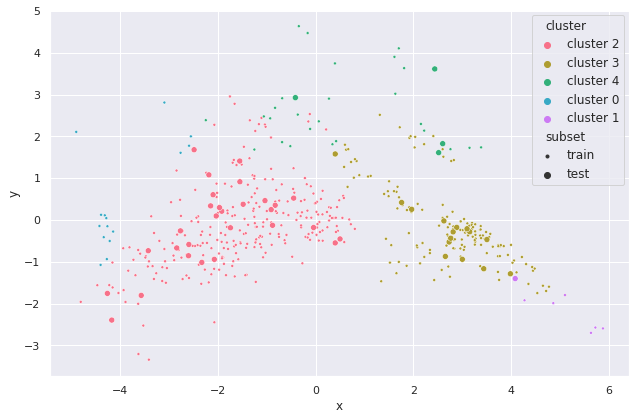

In [77]:
visualize_clusters(
  (boston_z_train, p_train, 'train', '.'),
  (boston_z_test, p_test, 'test', 'o'),
)

##### Discussions

We re-use the 99% energy reduction previously performed and select $e=5.0$, as higher values would create a massive central cluster and only two residual ones.

The results obtained here were very similar to the ones without the use of PCA. Once again, we observe clusters **0** and **1** containing a few sparsely positioned samples, while cluster **2** and **3** contain most samples of the set. Cluster **4** is positioned on the top-middle of the space, between **2** and **3**, and contains fewer samples than both.

## References

1. Kriegel, HP., Schubert, E. & Zimek, A. The (black) art of runtime evaluation: Are we comparing algorithms or implementations?. Knowl Inf Syst 52, 341–378 (2017). https://doi.org/10.1007/s10115-016-1004-2
2. Pedregosa, F. et. al. Scikit-learn: Machine Learning in Python: *sklearn.metrics.silhouette_score*. Accessed at Apr. 12 2021. [link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
3. Harrison, D. and Rubinfeld, D.L. `Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978. [link](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)
4. Pedregosa, F. et. al. Scikit-learn: Machine Learning in Python: *Data Standardization*. Accessed at Apr. 15 2021. [link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
5. Wikipedia. k-means clustering. Accessed at Apr. 17 2021. [link](https://en.wikipedia.org/wiki/K-means_clustering)